In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1 General Port Parameters

In [2]:
year              = 2018   # current year within simulation
simulation_window = 20     # looking 20 years ahead
start_year        = 2018   # start year of simulation
timestep          = year - start_year
operational_hours = 8760   # operational hours per year

# 2 Scenario Generator

In [3]:
from terminal_optimization.forecast import maize, soybean, wheat, handysize, handymax, panamax
from terminal_optimization.plot_file import plot_trend

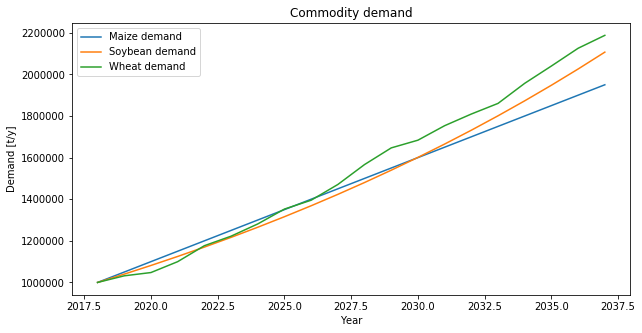

In [4]:
# Generating a single demand forecast

# Maize - Linear demand
demand_maize  = 1000000        # demand at t=0
growth_maize  = 50000       

# Soybean - Exponential demand
demand_soybean = 1000000
rate_soybean   = 1.04          # year on year growth rate of demand (% points) - input for constant method and random method

# Wheat - Probabilistic demand
demand_wheat   = 1000000
rate_wheat     = 1.03
mu_wheat       = 0.01          # avg bonus rate added to base rate (% points)  - input for random method
sigma_wheat    = 0.015         # standard deviation of bonus rate (% points)   - input for random method

maize.linear_forecast        (year, simulation_window, demand_maize, growth_maize)
soybean.exponential_forecast (year, simulation_window, demand_soybean, rate_soybean)
wheat.random_forecast        (year, simulation_window, demand_wheat, rate_wheat, mu_wheat, sigma_wheat)

plot_trend(maize, soybean, wheat, 10, 5)

# Port Model

In [5]:
import terminal_optimization.investment_decisions as invest
import terminal_optimization.infrastructure       as infra
import terminal_optimization.business_logic       as financial

In [6]:
asset_objects = [infra.quay_object, infra.berth_object, infra.cranes_object, infra.storage_object, 
                 infra.station_object, infra.quay_conveyor_object, infra.hinterland_conveyor_object]
assets        = 7*[0]
vessels       = [handysize, handymax, panamax]

## 3.2 Investment decisions

In [7]:
allowable_berth_occupancy = 0.40

# Simulator

In [8]:
def simulate(year, timestep):
    if timestep == 0: 
        quays  = [infra.quay_object]
        berths = [infra.berth_object]
        cranes = [infra.cranes_object]
        storage = [infra.storage_object]
        stations = [infra.station_object]
        q_conveyors = [infra.quay_conveyor_object]
        h_conveyors = [infra.hinterland_conveyor_object]

    # Berths
    allowable_berth_occupancy = 0.40
    berths, cranes = invest.berth_invest_decision(berths, cranes, infra.berth_object, infra.cranes_object,
                                                  allowable_berth_occupancy, vessels, year, timestep, operational_hours)
    # Quay
    quays = invest.quay_invest_decision(quays, berths, infra.quay_object, year, timestep)

In [9]:
simulate(year, timestep)

Number of berths added:   1
Pending number of berths: 1
Current number of berths: 0

250
Meters of quay added:  250
Current quay length:   0



### 3.2.3 Crane investment decision
In this setup, the number of cranes is solely goverened by the number of berths. The number of cranes per berth is equal to the number of cranes that can work simultaeously on the largest vessel that calls to port during the current timestep. E.g. two cranes per berth in years where handymax is the largest vessel and three cranes per berth in years where panamax is the largest vessel

In [10]:
# at t=0 import cranes class from infrastructure package and run initial crane configuration
if timestep == 0:
    cranes = invest.initial_crane_setup(cranes)
    
# for each time step, check whether pending assets come online
cranes = invest.crane_online_transition(cranes, year)
    
# for each time step, decide whether to invest in the cranes
crane_invest_decision = invest.crane_invest_decision(cranes, berths, year)

# if investments are needed, calculate how much cranes should be added
if crane_invest_decision == 'Invest in cranes':
    cranes = invest.crane_expansion(cranes, cranes_object, berths, year)
else:
    for i in range (4):
        cranes[i][0].delta = 0

print ('Number of berths added:', berths[0].delta)
print ('Gantry cranes added:   ', cranes[0][0].delta)
print ('Harbour cranes added:  ', cranes[1][0].delta)
print ('Mobile cranes added:   ', cranes[2][0].delta)
print ('Screw unloaders added: ', cranes[3][0].delta)

NameError: name 'cranes' is not defined

### 3.2.3 Storage investment decision
In this setup, the storage investment is triggered whenever the storage capacity equals 10% of yearly demand. Once triggered, the storage is expanded to accomodate 20% of yearly throughput

In [ ]:
# at t=0 import storage class from infrastructure package and run initial storage configuration
if timestep == 0:
    silo_object = infra.silo_object
    warehouse_object = infra.warehouse_object
    storage = [[silo_object], [warehouse_object]]
    storage = invest.initial_storage_setup(storage)
    
# for each time step, check whether pending assets come online
storage = invest.storage_online_transition(storage, year)
    
# for each time step, decide whether to invest in storage
invest_decision = invest.storage_invest_decision(storage, maize, soybean, wheat, timestep)
storage_invest_decision = invest_decision[0]
storage = invest_decision[1]

# if investments are needed, calculate how much extra capacity should be added
if storage_invest_decision == 'Invest in storage':
    storage = invest.storage_expansion(storage, year)
else:
    storage[0][0].delta = 0
    storage[1][0].delta = 0

print ('Silo capacity added (t):       ', storage[0][0].delta)
print ('Current silo capacity (t):     ', storage[0][0].online_capacity)
print ('Warehouse capacity added (t):  ', storage[1][0].delta)
print ('Current warehouse capacity (t):', storage[1][0].online_capacity)

### 3.2.4 Loading station investment decision
In this setup, it is assumed that the loading station has a utilisation rate of 60%. The loading station investment is triggered whenever the yearly loading capacity equals 80% of yearly demand, taking the utilisation rate into account. Once triggered, the loading rate is expanded to accomodate 120% of yearly throughput in steps of 300 t/h

In [ ]:
# at t=0 import loading station class from infrastructure package and run initial laoding station configuration
if timestep == 0:
    station_object = infra.station_object
    stations = [station_object]
    station_object = invest.initial_station_setup(stations)
    
# for each time step, check whether pending assets come online
stations = invest.station_online_transition(stations, year)
    
# for each time step, decide whether to invest in storage
stations_invest_decision = invest.station_invest_decision(stations, maize, soybean, wheat, timestep, operational_hours)

# if investments are needed, calculate how much extra capacity should be added
if stations_invest_decision == 'Invest in loading stations':
    stations = invest.station_expansion(stations, maize, soybean, wheat, year, timestep, operational_hours)
else:
    stations[0].delta = 0

print ('Loading station capacity added (t/h):  ', stations[0].delta)
print ('Current loading station capacity (t/h):', stations[0].online_capacity)

### 3.2.5 Conveyor investment decision
#### 3.2.5.1 Quay conveyor
In this setup, the quay-side conveyor investment dicision is triggered whenever the the crane investment is triggered. The conveyor capacity is always sufficient to cope with the cranes' peak unloading capacity. It is assumed that each additional conveyor built increases conveying capacity by 400 t/h.

In [ ]:
# at t=0 import conveyor class from infrastructure package and run initial conveyor configuration
if timestep == 0:
    quay_conveyor_object = infra.quay_conveyor_object
    q_conveyors = [quay_conveyor_object]
    q_conveyors = invest.initial_conveyor_setup(q_conveyors)
    
# for each time step, check whether pending assets come online
q_conveyors = invest.conveyor_online_transition(q_conveyors, year)
    
# for each time step, decide whether to invest in quay conveyors
invest_decision = invest.quay_conveyor_invest_decision(q_conveyors, cranes)
quay_conveyor_invest_decision = invest_decision[0]
q_conveyors = invest_decision[1]

# if investments are needed, calculate how much extra capacity should be added
if quay_conveyor_invest_decision == 'Invest in quay conveyors':
    q_conveyors = invest.quay_conveyor_expansion(q_conveyors, cranes, year)
else:
    q_conveyors[0].delta = 0

print ('Quay conveyor length (m):             ', q_conveyors[0].length)
print ('Quay conveying capacity added (t/h):  ', q_conveyors[0].delta)
print ('Current quay conveying capacity (t/h):', q_conveyors[0].online_capacity)

#### 3.2.5.1 Hinterland conveyor
In this setup, the hinterland conveyor investment dicision is triggered whenever the loading station investment is triggered. The conveyor capacity is always sufficient to cope with the hinterland loading stations' capacity. It is assumed that each additional conveyor built increases conveying capacity by 400 t/h.

In [ ]:
# at t=0 import conveyor class from infrastructure package and run initial conveyor configuration
if timestep == 0:
    hinterland_conveyor_object = infra.hinterland_conveyor_object
    h_conveyors = [hinterland_conveyor_object]
    h_conveyors = invest.initial_conveyor_setup(h_conveyors)
    
# for each time step, check whether pending assets come online
h_conveyors = invest.conveyor_online_transition(h_conveyors, year)
    
# for each time step, decide whether to invest in quay conveyors
invest_decision = invest.hinterland_conveyor_invest_decision(h_conveyors, stations)
quay_conveyor_invest_decision = invest_decision[0]
h_conveyors = invest_decision[1]

# if investments are needed, calculate how much extra capacity should be added
if quay_conveyor_invest_decision == 'Invest in hinterland conveyors':
    h_conveyors = invest.hinterland_conveyor_expansion(h_conveyors, stations, year)
else:
    h_conveyors[0].delta = 0

print ('Hinterland conveyor length (m):             ', h_conveyors[0].length)
print ('Hinterland conveying capacity added (t/h):  ', h_conveyors[0].delta)
print ('Current hinterland conveying capacity (t/h):', h_conveyors[0].online_capacity)

## 3.4 Business Logic

In [ ]:
assets = [quays, berths, cranes, storage, stations, q_conveyors, h_conveyors]

### 3.4.1 Terminal Throughput

In [ ]:
# at t=0 create list that will hold yearly throughputs
if timestep == 0:
    throughputs = []
    
# for each time step, compute the terminal throughput
throughputs = financial.throughput_calc(throughputs, year, assets)

print ('Terminal throughput (t/y):  ',throughputs[timestep].total)

### 3.4.1 Revenue 

In [ ]:
# at t=0 create list that will hold yearly throughputs
if timestep == 0:
    revenues = []
    
# for each time step, compute the terminal throughput
revenues = financial.revenue_calc(revenues, maize, soybean, wheat, throughputs, year, timestep)

print ('Maize revenue ($):  ', revenues[timestep].maize)
print ('Soybean revenue ($):', revenues[timestep].soybean)
print ('Wheat revenue ($):  ', revenues[timestep].wheat)
print ('Total revenue ($):  ', revenues[timestep].total)

### 3.4.2 Capex

In [ ]:
# at t=0 create list that will hold yearly capex
if timestep == 0:
    capex = []
    
# for each time step, compute the capex
capex = financial.capex_calc(capex, assets, year)

print ('Quay capex($)           ', capex[timestep].quay)
print ('Crane capex($)          ', capex[timestep].cranes)
print ('Storage capex($)        ', capex[timestep].storage)
print ('Conveyor capex($)       ', capex[timestep].conveyors)
print ('Loading station capex($)', capex[timestep].loading_stations)
print ('Total capex ($):        ', capex[timestep].total)

### 3.4.3 Labour costs

In [ ]:
# at t=0 create list that will hold yearly labour costs
if timestep == 0:
    labour = []
    
# for each time step, compute the labour costs
labour = financial.labour_calc(labour, assets, year)
    
print ('International staff costs($):', labour[timestep].international_salary * labour[timestep].international_staff)
print ('Local staff costs($):        ', labour[timestep].local_salary         * labour[timestep].local_staff)
print ('Operational staff costs($):  ', labour[timestep].operational_salary   * labour[timestep].operational_staff)
print ('Total costs($):              ', labour[timestep].total)

### 3.4.4 Maintenance costs

In [ ]:
# at t=0 create list that will hold yearly maintenance costs
if timestep == 0:
    maintenance = []
    
# for each time step, compute the maintenance costs
maintenance = financial.maintenance_calc(maintenance, assets, year)

print ('Quay maintenance costs($):    ', maintenance[timestep].quay)
print ('Crane maintenance costs($):   ', maintenance[timestep].cranes)
print ('Storage maintenance costs($): ', maintenance[timestep].storage)
print ('Conveyor maintenance costs($):', maintenance[timestep].conveyors)
print ('Total maintenance costs($):   ', maintenance[timestep].total)

### 3.4.5 Energy costs

In [ ]:
# at t=0 create list that will hold yearly energy costs
if timestep == 0:
    energy = []
    
# for each time step, compute the maintenance costs
energy = financial.energy_calc(energy, assets, year, operational_hours)

print ('Crane energy costs($):           ', energy[timestep].cranes)
print ('Storage energy costs($):         ', energy[timestep].storage)
print ('Loading station energy costs($): ', energy[timestep].stations)
print ('Conveyor energy costs($):        ', energy[timestep].conveyors)
print ('Total energy costs($):           ', energy[timestep].total)

### Insurance costs

In [ ]:
# at t=0 create list that will hold yearly insurance costs
if timestep == 0:
    insurance = []
    
# for each time step, compute the maintenance costs
insurance = financial.insurance_calc(insurance, assets, year)

print ('Quay insurance costs($):            ', insurance[timestep].quay)
print ('Crane insurance costs($):           ', insurance[timestep].cranes)
print ('Storage insurance costs($):         ', insurance[timestep].storage)
print ('Loading station insurance costs($): ', insurance[timestep].stations)
print ('Conveyor insurance costs($):        ', insurance[timestep].conveyors)
print ('Total insurance costs($):           ', insurance[timestep].total)

### Lease costs

In [ ]:
# at t=0 create list that will hold yearly lease costs
if timestep == 0:
    lease = []
    
# for each time step, compute the lease costs
lease = financial.lease_calc(lease, assets)

print ('Total lease costs($):', lease[timestep].total)

### 3.4.6 Demurrage costs

In [ ]:
# at t=0 create list that will hold yearly energy costs
if timestep == 0:
    demurrage = []
    
# for each time step, compute the demurrage costs
demurrage = financial.demurrage_calc(demurrage, year, berths, handysize, handymax, panamax, timestep)

print ('Handysize demurrage costs($):', demurrage[timestep].handysize)
print ('Handymax demurrage costs($): ', demurrage[timestep].handymax)
print ('Panamax demurrage costs($):  ', demurrage[timestep].panamax)
print ('Total demurrage costs($):    ', demurrage[timestep].total)

### Residual Values

In [ ]:
# at t=0 create list that will hold the yearly residual value of all terminal assets
if timestep == 0:
    residuals = []
    
# for each time step, compute the resiual value of all terminal assets
residuals = financial.residual_calc(residuals, assets, year)

print ('Total residual value ($)', residuals[timestep].total)

### Profits

In [ ]:
# at t=0 create list that will hold yearly profits
if timestep == 0:
    profits = []
    
# for each time step, compute the proft/loss
profits = financial.profit_calc(profits, revenues, capex, labour, maintenance, energy, insurance, lease, demurrage, residuals, 
                                simulation_window, timestep, year, start_year)

print ('Total profit/loss ($)', profits[timestep].total)